In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import networkx as nx  
import pandas as pd
import numpy as np
from scipy import sparse
import gc

## Utility functions
Utility functions created to process data from long dictionaries.

>### degree_freq(G)

<br>**PARAMETERS:** G (graph) – A NetworkX graph.
<br>
<br>**RETURNS:**
<br>in_deg_freq --> Dictionary of Indegree values (as keys) and the number of nodes that have that indegree  (as a value).
<br>out_deg_freq --> Dictionary of Outdegree values (as keys) and the number of nodes that have that outdegree (as a value).
<br>all_in_deg --> Dictionary of all nodes, with their indegree as value (native function of NetworkX does not return a dictionary)
<br> all_out_deg --> Dictionary of all nodes, with their outdegree as value (native function of NetworkX does not return a dictionary)
<br>
<br>**RETURN TYPE:** dictionary


In [2]:
def degree_freq(graph):
    in_deg_freq = {}
    all_in_deg ={}

    out_deg_freq = {}
    all_out_deg ={}
    
    for n in graph.nodes():
        in_deg = graph.in_degree(n)
        out_deg= graph.out_degree(n)
        
        all_in_deg[n] = in_deg
        all_out_deg[n]= out_deg
        
        if in_deg not in in_deg_freq:
            in_deg_freq[in_deg] = 0
        in_deg_freq[in_deg]+= 1
        
        if out_deg not in out_deg_freq:
            out_deg_freq[out_deg] = 0
        out_deg_freq[out_deg]+= 1      
    
    return in_deg_freq, all_in_deg, out_deg_freq, all_out_deg

>### get_top_values(d, t)

Given a dictionary, this function orders it by the value (descending order) and returns a smaller dictionary with the N-top values with their keys.
**PARAMETERS:** 
<br> d (dictionary) – a dictionary with un-ordered values
<br> t (int) – the number of top values to retrieve
<br>**RETURNS:**
<br> new_d --> Dictionary with ordered keys, with highest values.
<br>**RETURN TYPE:** dictionary


In [3]:
def get_top_values(d, t):
    new_d={}
    sorted_keys = sorted(d, key=d.get, reverse=True)
    for x in sorted_keys[:t]:
        new_d[x] = d[x]
    return new_d

>### get_top_keys(D,top)

Given a dictionary, this function orders it by the key (descending order) and returns a list of tuples, with the N-top keys and their values.
**PARAMETERS:** 
<br> D (dictionary) – a dictionary with un-ordered keys
<br> top (int) – the number of n top values 
<br>**RETURNS:**
<br> item --> List of tuples (key,value)
<br>**RETURN TYPE:** list


In [4]:
def get_top_keys(dictionary, top):
    item = list(reversed(sorted(dictionary.items())))
    return item[:top]

## Load dataset of users & followers
For this purpose, we are using the files *followers.csv* and *users.csv*, contained in the MySQL dump that is published by **The GHTorrent project**.
<br>The file *followers.csv* contains three columns, containing the date of creation of the link and the user IDs, indicating if a user follows another. In graphs and network theory, this type of table it is know as "adjacency list". 
<br>
<br>The file *users.csv* contains several columns with user information(user name, id, creation of the account, country, company, email, etc). We use this table only to map the relationship between *user ID number* and *login name*.
<br>
<br>The used tables contain all users ( and their relationships) that were created **until January 2019**.
<br>
<br>__[Link to download the MySQL dump: mysql-2019-01-01.tar.gz (size of 90.1 GB)](http://ghtorrent-downloads.ewi.tudelft.nl/mysql/mysql-2019-01-01.tar.gz)__

In [20]:
#LOAD DATA FROM CSV, only load the first two columns
file_path1 = r'.\..\2018\followers.csv'
df_f = pd.read_csv(file_path1, index_col=False, usecols=[0,1], names=['follower_id', 'user_id'])

In [11]:
#LOAD DATA FROM CSV, only load the first two columns
#file_path2 = r'.\2018\users.csv'
#df_u = pd.read_csv(file_path2, sep=',', index_col=False, usecols=[0,1], names=['id','login'])

df_u = pd.read_csv(r'.\..\2018\users.csv', sep=',', index_col=False, error_bad_lines=False)

b'Skipping line 28844: expected 13 fields, saw 14\n'
b'Skipping line 127060: expected 13 fields, saw 16\nSkipping line 130093: expected 13 fields, saw 14\n'
b'Skipping line 140110: expected 13 fields, saw 14\n'
b'Skipping line 223215: expected 13 fields, saw 16\nSkipping line 240360: expected 13 fields, saw 15\n'
b'Skipping line 274140: expected 13 fields, saw 14\nSkipping line 287603: expected 13 fields, saw 14\nSkipping line 303874: expected 13 fields, saw 14\nSkipping line 327509: expected 13 fields, saw 15\n'
b'Skipping line 455083: expected 13 fields, saw 14\n'
b'Skipping line 491713: expected 13 fields, saw 14\n'
b'Skipping line 828312: expected 13 fields, saw 14\n'
b'Skipping line 870291: expected 13 fields, saw 15\n'
b'Skipping line 935277: expected 13 fields, saw 14\n'
b'Skipping line 1117721: expected 13 fields, saw 24\nSkipping line 1132208: expected 13 fields, saw 14\n'
b'Skipping line 1257324: expected 13 fields, saw 15\n'
b'Skipping line 1353050: expected 13 fields, saw 1

In [12]:
#We need to cut the columns we are not going to use and change the header of the dataframe
df_u.columns = ['id', 'login','company','created_at','type','fake','deleted','long','lat','country_code','state','city','location']
cols_to_keep = ['id', 'login','type']
df_u = df_u[cols_to_keep]
df_u.head()

,id,login,type
0,1,tosch,USR
1,2,jmettraux,USR
2,3,SMGNMSKD,USR
3,4,kennethkalmer,USR
4,5,weppos,USR


In [ ]:
df_u.head()

In [13]:
#we are not considering the ORG (organization accounts) and the ones labeled with 0 (innactive accounts)
df_ORG = df_u.loc[ df_u['type']=='ORG']
df_zero= df_u.loc[ df_u['type']=='0']

# we don't need this columns
del df_ORG['login']
del df_ORG['type']
del df_zero['login']
del df_zero['type']

In [15]:
gc.collect()
gc.collect()

20

0

In [16]:
print("Number of users:", df_u.shape[0])

Number of users: 29542940


In [36]:
import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)


[('df_trim', 710007720),
 ('InteractiveShell', 1056),
 ('degree_freq', 136),
 ('get_top_keys', 136),
 ('get_top_values', 136),
 ('file_path1', 120),
 ('cols_to_keep', 88),
 ('np', 80),
 ('nx', 80),
 ('pd', 80),
 ('plt', 80),
 ('sparse', 80)]

In [21]:
# 1 - delete nodes from the 'user_id' col, that are ZERO type
df_trim = df_f[~df_f.user_id.isin(df_zero.id)]

# delete nodes form the 'follower_id' col, that are ZERO type
df_trim = df_trim[~df_trim.follower_id.isin(df_zero.id)]

In [23]:
# 3 - delete nodes that are ORG type
df_trim = df_trim[~df_trim.user_id.isin(df_ORG.id)]
df_trim = df_trim[~df_trim.follower_id.isin(df_ORG.id)]

In [24]:
#29,583,654 - edges
df_trim.shape[0]

29583654

In [25]:
#3,775,490 - Users
len(df_trim['user_id'].unique())

3775490

In [27]:
df_trim.head()

,follower_id,user_id
0,1,2
1,1,4
2,1,17896
3,1,21523
4,1,29121


In [31]:
#free memory
del df_u
del df_f
del df_ORG
del df_zero


In [33]:
gc.collect()
gc.collect()



20

0

In [35]:
#save to CSV
df_trim.to_csv('df_trim.csv', header=False, index=False)

In [6]:
#load from CSV
df_trim = pd.read_csv('df_trim.csv', index_col=False, names=['follower_id', 'user_id'])

In [7]:
df_trim.head()

,follower_id,user_id
0,1,2
1,1,4
2,1,17896
3,1,21523
4,1,29121


### Preliminar size of full network
Before creating the Network, we can get some preliminar statistic about it:
<br>Number of users = **3,775,490**
<br>Number of edges (connections) = **29,583,654**
<br>
<br>At this point we have not validated if all listed users in file *users.csv* have an entry in *followers.csv*

In [8]:
print("Number of users:", len(df_trim['user_id'].unique()))
print("Number of edges:", df_trim.shape[0])

Number of users: 3775490
Number of edges: 29583654


### Create full network of users

In [9]:
#create empty directed Graph
full_followers_graph = nx.DiGraph()

In [10]:
# the directed graph maps the direction as: [follower --> user]
# for this purpose, the graph is created using the dataframe as a list
full_followers_graph.add_edges_from(df_trim.values.tolist())

In [11]:
# print and check some stats about the full network
print(nx.info(full_followers_graph))

Name: 
Type: DiGraph
Number of nodes: 5351128
Number of edges: 29583654
Average in degree:   5.5285
Average out degree:   5.5285


In [12]:
# calculates some statistics
in_deg_freq, all_in_deg, out_deg_freq, all_out_deg = degree_freq(full_followers_graph)

In [28]:
#save information in csv file

(pd.DataFrame.from_dict(data=in_deg_freq, orient='index').to_csv('in_deg_freq.csv'))
(pd.DataFrame.from_dict(data=all_in_deg,  orient='index').to_csv('all_in_deg.csv'))
(pd.DataFrame.from_dict(data=out_deg_freq,orient='index').to_csv('out_deg_freq.csv'))
(pd.DataFrame.from_dict(data=all_out_deg, orient='index').to_csv('all_out_deg.csv'))



In [13]:
#parses list of indegree values and outdegree values
idf = (sorted(in_deg_freq.items()))
odf = (sorted(out_deg_freq.items()))

In [36]:
#idf[-20:]

<Figure size 504x396 with 0 Axes>

Text(0, 0.5, 'Degree')

Text(0.5, 0, 'Number of nodes')

Text(0.5, 1.0, 'Followers network in Github')

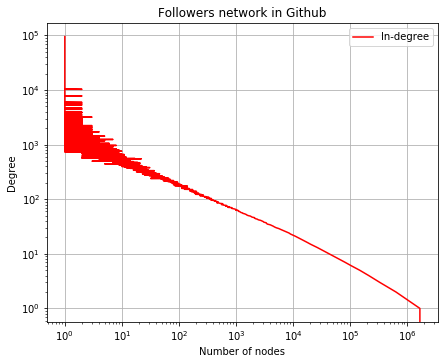

<Figure size 432x288 with 0 Axes>

In [40]:
#plot degree frequency

plt.figure(figsize =(7, 5.5))
plt.grid(True)
plt.loglog([v for (k,v) in idf], [k for (k,v) in idf], 'r-') # in-degree
#plt.loglog([k for (k,v) in odf],[v for (k,v ) in odf], 'b-')  # out-degree
plt.legend(['In-degree', 'Out-degree'])
plt.ylabel('Degree')
plt.xlabel('Number of nodes')
plt.title('Followers network in Github')


fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('degree_distribution_2019.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
#save to CSV
df_trim.to_csv('df_trim.csv', header=False, index=False)

In [18]:
#since we are not doing further calculations with this full network, we release the memory 
del full_followers_graph

In [20]:
#use the Garbage collect utility
gc.collect()
gc.collect()

20

0